Capstone - EV Price Regression

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer


In [8]:
df = pd.read_csv('EV_cars.csv')

In [9]:
df.head()

,Battery,Car_name,Car_name_link,Efficiency,Fast_charge,Price.DE.,Range,Top_speed,acceleration..0.100.
0,75.0,Tesla Model Y Long Range Dual Motor,https://ev-database.org/car/1619/Tesla-Model-Y...,172,670.0,59017.0,435,217,5.0
1,57.5,Tesla Model 3,https://ev-database.org/car/1991/Tesla-Model-3,137,700.0,46220.0,420,201,6.1
2,60.5,BYD ATTO 3,https://ev-database.org/car/1782/BYD-ATTO-3,183,370.0,44625.0,330,160,7.3
3,61.7,MG MG4 Electric 64 kWh,https://ev-database.org/car/1708/MG-MG4-Electr...,171,630.0,39990.0,360,160,7.9
4,75.0,Tesla Model 3 Long Range Dual Motor,https://ev-database.org/car/1992/Tesla-Model-3...,149,780.0,55220.0,505,201,4.4


In [12]:
# Let's cleanup some column names
df.columns = df.columns.str.lower()
df.rename({"price.de.":"price","acceleration..0.100.":"acceleration0to100"}, inplace = True, axis = 1)

In [16]:
# Check for nulls
df.isnull().sum()

battery               0
car_name              0
car_name_link         0
efficiency            0
fast_charge           2
price                 0
range                 0
top_speed             0
acceleration0to100    0
dtype: int64

In [18]:
# We want price to be the target variable, so we'll have to remove records where price is null
df = df[~df["price"].isna()]

In [19]:
# Let's remove any rows w/ nulls since there are very few of them
df = df[~df["fast_charge"].isna()]

In [49]:
# Let's just grab the numeric columns
df_numeric = df[["battery","efficiency","fast_charge","range","top_speed","acceleration0to100","price"]]

In [50]:
df_numeric.describe()

,battery,efficiency,fast_charge,range,top_speed,acceleration0to100,price
count,307.000000,307.000000,307.000000,307.000000,307.000000,307.000000,307.000000
mean,71.386319,195.586319,552.833876,370.602606,181.429967,7.275896,67529.882736
std,20.363656,32.672692,240.318651,107.870255,36.479166,3.087695,34462.344923
min,21.300000,137.000000,170.000000,135.000000,125.000000,2.100000,22550.000000
25%,57.500000,171.000000,335.000000,297.500000,155.000000,4.800000,45867.500000
50%,70.500000,188.000000,520.000000,380.000000,180.000000,6.700000,56950.000000
75%,85.000000,209.500000,680.000000,447.500000,200.500000,9.000000,73624.500000
max,123.000000,295.000000,1290.000000,685.000000,282.000000,19.100000,218000.000000


In [45]:
# Let's look at min/max values
for column in df_numeric.columns:
    print(f"{column} \nMin: {df_numeric[column].min()} | Max: {df_numeric[column].max()}\n")

battery 
Min: 21.3 | Max: 123.0

efficiency 
Min: 137 | Max: 295

fast_charge 
Min: 170.0 | Max: 1290.0

range 
Min: 135 | Max: 685

top_speed 
Min: 125 | Max: 282

acceleration0to100 
Min: 2.1 | Max: 19.1

price 
Min: 22550.0 | Max: 218000.0



In [23]:
# Let's check corr_matrix for the numeric features
corr_matrix = df_numeric.corr()

<Axes: >

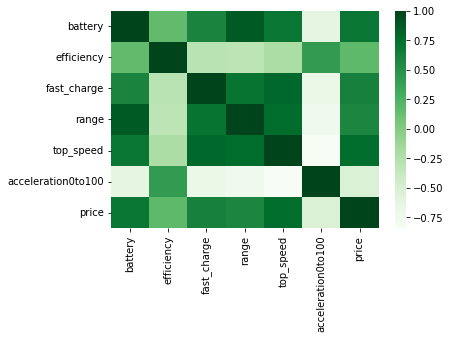

In [27]:
sns.heatmap(corr_matrix, cmap='Greens')

Looks like accelerations, battery, and top_speed are some of our most impactful features

array([<Axes: title={'center': 'battery'}>,
       <Axes: title={'center': 'efficiency'}>,
       <Axes: title={'center': 'fast_charge'}>,
       <Axes: title={'center': 'price'}>,
       <Axes: title={'center': 'range'}>,
       <Axes: title={'center': 'top_speed'}>,
       <Axes: title={'center': 'acceleration0to100'}>], dtype=object)

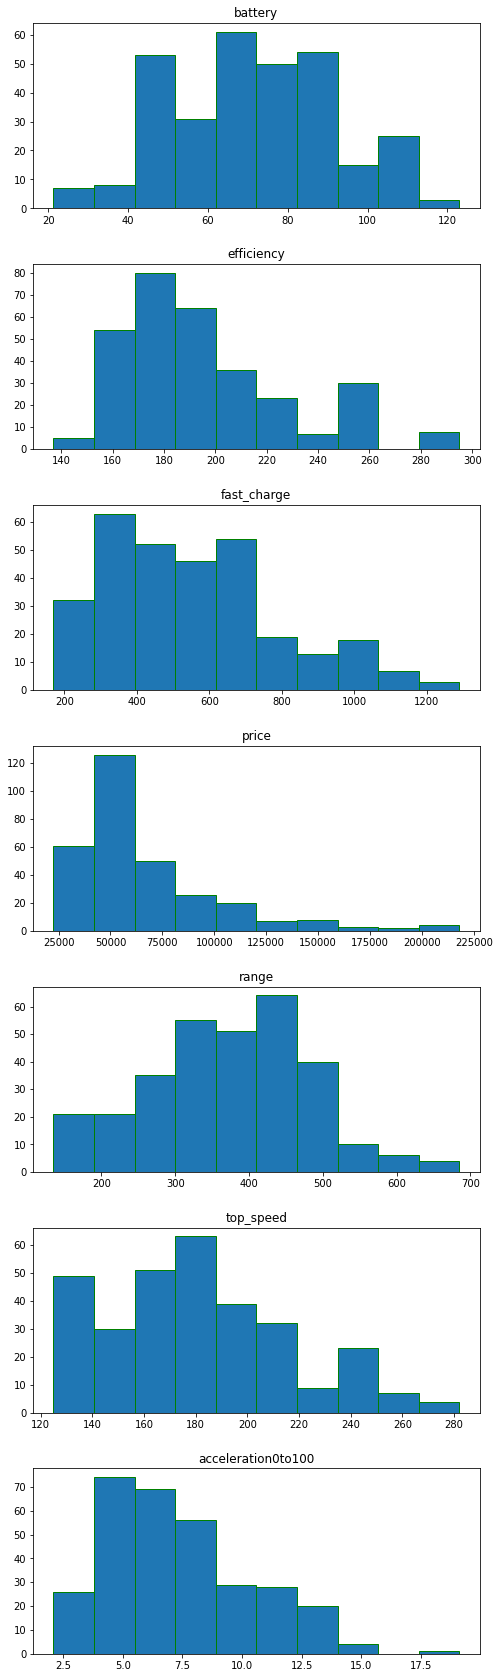

In [32]:
# Checking out the histograms
fig, axis = plt.subplots(7, 1, figsize=(8,30))
df.hist(ax=axis, grid=False, edgecolor='green')

Looks like price has a very long tail so we'll want to normalize it

In [84]:
# splitting the data | just using numeric columns since the others (name and url) aren't very useful
df_train, df_test = train_test_split(df_numeric, test_size=0.2, random_state=42)

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = np.log(df_train.price.values)
y_test = np.log(df_test.price.values)

del df_train['price']
del df_test['price']

In [85]:
dv = DictVectorizer(sparse=False)

train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

test_dict = df_test.to_dict(orient='records')
X_test = dv.transform(test_dict)

In [91]:
# let's try KNN regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
for n in range(1,21):
    knn = KNeighborsRegressor(n_neighbors=n)
    knn.fit(X_train, y_train)

    y_pred = knn.predict(X_test)

    score = mean_squared_error(y_test, y_pred)
    print(f"n={n} score={score}")

n=1 score=0.049811625732853
n=2 score=0.03716586448311042
n=3 score=0.038504511575045676
n=4 score=0.04080125736492821
n=5 score=0.04254152595432118
n=6 score=0.03787477576259417
n=7 score=0.03952984927267638
n=8 score=0.038369107574061145
n=9 score=0.041938779370460574
n=10 score=0.04269482797552597
n=11 score=0.04240688239455573
n=12 score=0.04277214248657032
n=13 score=0.04330692315996539
n=14 score=0.044516862647283835
n=15 score=0.046060413690165676
n=16 score=0.04617688682378653
n=17 score=0.04635903425861945
n=18 score=0.04858019425601341
n=19 score=0.048859146674236895
n=20 score=0.04867481275557602


Looks like our best mse was 0.03716586448311042 with n=2

Now let's try xgboost regression

In [102]:
import xgboost as xgb

features = dv.feature_names_

Dtrain = xgb.DMatrix(X_train, label = y_train, feature_names = features)
Dtest = xgb.DMatrix(X_test, label = y_test, feature_names = features)


In [103]:
watchlist = [(Dtrain, 'train'), (Dtest, 'test')]

def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_score', 'test_score']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

I'll test some different learning rates

In [104]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, Dtrain, num_boost_round=100,verbose_eval=5,evals=watchlist)

In [105]:
parse_xgb_output(output)

,num_iter,train_score,test_score
0,0,0.32298,0.28133
1,5,0.09260,0.12834
2,10,0.04787,0.12673
3,15,0.03555,0.12816
4,20,0.02939,0.12961
5,25,0.02731,0.12992
6,30,0.02551,0.13012
7,35,0.02441,0.13045
8,40,0.02348,0.13107
9,45,0.02319,0.13146


In [111]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, Dtrain, num_boost_round=100,verbose_eval=5,evals=watchlist)


In [112]:
parse_xgb_output(output)

,num_iter,train_score,test_score
0,0,0.39673,0.34651
1,5,0.25615,0.22893
2,10,0.17078,0.17036
3,15,0.11819,0.14057
4,20,0.08605,0.12815
5,25,0.06666,0.12398
6,30,0.05432,0.12270
7,35,0.04647,0.12150
8,40,0.04079,0.12174
9,45,0.03707,0.12214


In [113]:
%%capture output

xgb_params = {
    'eta': 0.5, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, Dtrain, num_boost_round=100,verbose_eval=5,evals=watchlist)


In [114]:
parse_xgb_output(output)

,num_iter,train_score,test_score
0,0,0.25210,0.22241
1,5,0.05053,0.13231
2,10,0.03312,0.14000
3,15,0.02668,0.14320
4,20,0.02385,0.14486
5,25,0.02322,0.14485
6,30,0.02277,0.14530
7,35,0.02265,0.14540
8,40,0.02258,0.14537
9,45,0.02254,0.14545


I like having a slower learning rates of 0.1 and letting it run to about 35 rounds.

Now let's try a couple max_depth options

In [136]:
%%capture output
scores = {}
for max_depth in [1,2,3,4,5,6,7,8,9,10]:
    xgb_params = {
        'eta': 0.1, 
        'max_depth': max_depth,
        'min_child_weight': 1,

        'objective': 'reg:squarederror',
        'nthread': 8,

        'seed': 1,
        'verbosity': 1,
    }

    model = xgb.train(xgb_params, Dtrain, num_boost_round=100,verbose_eval=5,evals=watchlist)
    scores[max_depth] = parse_xgb_output(output).test_score.min()
    

In [137]:
scores

{1: 0.11181,
 2: 0.11181,
 3: 0.11181,
 4: 0.11181,
 5: 0.11181,
 6: 0.11181,
 7: 0.11181,
 8: 0.11181,
 9: 0.11181,
 10: 0.11181}

max_depth not having any impact

Let's try a coulpe min_child_weight options

In [138]:
%%capture output
scores = {}
for min_child_weight in [1,2,3,4,5,6,7,8,9,10]:
    xgb_params = {
        'eta': 0.1, 
        'max_depth': 6,
        'min_child_weight': min_child_weight,

        'objective': 'reg:squarederror',
        'nthread': 8,

        'seed': 1,
        'verbosity': 1,
    }

    model = xgb.train(xgb_params, Dtrain, num_boost_round=100,verbose_eval=5,evals=watchlist)
    scores[min_child_weight] = parse_xgb_output(output).test_score.min()
    

In [139]:
scores

{1: 0.11181,
 2: 0.11181,
 3: 0.11181,
 4: 0.11181,
 5: 0.11181,
 6: 0.11181,
 7: 0.11181,
 8: 0.11181,
 9: 0.11181,
 10: 0.11181}

Same w/ min_child_weight, so we'll just rock the standard values of max_depth = 6 and min_child_weight = 1

Final Model:

In [140]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': min_child_weight,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, Dtrain, num_boost_round=35)
